# Project Report DM4BEM
- Student: Etienne Gubler (gubleet1)
- Year: 2023

# Comparing the simulation of a single thermal circuit to the simulation of a thermal circuit assembled from multiple sub networks
**Summary:**
- The heat transfer in **two connected rooms** is modeled using a thermal circuit.
- This **thermal circuit** is implemented **as a single network and** also **as** a combination of **multiple sub networks**.
- Then the **mathematical model as a system of differential algebraic equations (DAE)** is obtained for both versions of the thermal circuit.
- The systems of DAE are transformed into **state-space representations** to allow the thermal circuits to be simulated.
- The **simulation** is then performed **using the Euler methods** (both explicit and implicit) for numerical integration.
- In the end, **the outcome of the two simulations is being compared**. This is done to **ensure, that the result of a simulation does not depend on the method** that is used to create the thermal circuit (using either a single or an assembled network).
- Both simulated thermal circuits model the same physical components and **should** therefore **lead to identical results**.

# Introduction

![two rooms picture](./img/two-rooms_picture_01.jpg)
> Figure 0. The two rooms (connected through a glass window) which will be modeled as a thermal circuit for simulation. The simulation considers the state where the galss door of the separating wall is closed.

# Prolem definiton

## Symbols

# Physical Model

Importing the Python modules required to implement the thermal circuit as a model for simulation:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

from IPython.display import HTML

Defining functions to format the output of matrices, vectors and other values:

In [2]:
# highlight all cells containing non-zero values using a yellow background color
def highlight_nonzero(value):
    return 'background-color: yellow;' if value != 0 else None

# set the specified precisions for zero and non-zero values respectively
# non-zero values can be printed using scientific notation
def sparse_precision(value, zero=0, nonzero=1, scientific=False):
    if value == 0:
        return '{0:.{1}f}'.format(value, zero)
    else:
        return '{{0:.{{1}}{}}}'.format('e' if scientific else 'f').format(value, nonzero)

# display a matrix or vector (represented by a pandas DataFrame object) using HTML
def disp_mat(df, uuid, display_format={}):
    # get the Styler object and set the specified UUID
    styler = df.style
    styler.set_uuid(uuid)
    # data type
    data_type = display_format.get('data_type', 'float')
    match data_type:
        case 'float':
            styler.format(sparse_precision)
        case 'scientific':
            styler.format(lambda v: sparse_precision(v, nonzero=2, scientific=True))
        case 'int':
            styler.format(precision=0)
    # styling
    styling = display_format.get('styling', ['highlight-nonzero'])
    if 'highlight-nonzero' in styling:
        styler.applymap(highlight_nonzero)
    # display the HTML representation of the Styler object
    display(styler, include=['text/html'])

# display a large row vector (represented by a pandas DataFrame object)
# the length of the vector is truncated to the specified number of elements
def disp_row(df, n):
    pd.set_option('display.max_columns', n)
    display(df)
    pd.reset_option('display.max_columns')

# display a pass or fail test result
def disp_test(result):
    html_passed = '<p style="text-align: center; color: green;">Test passed.</p>'
    html_failed = '<p style="text-align: center; color: red;">Test failed.</p>'
    display(HTML(html_passed if result else html_failed), include=['text/html'])

## Description of the two connected rooms
![two rooms](./img/two-rooms_drawing_01.jpg)
> Figure 1. Two rooms connected through a glass window. One room has a window towards the outside. The walls consist of concrete with one layer of insulation.

The wall around the two connected rooms is split into two sections as follows (also see *Figure 1*):
- Wall A around the left room (including floor and ceiling)
- Wall B around the right room (including floor and ceiling)

The dimensions and surface areas of all walls and windows that make up the two connected rooms are as follows:
- $l_1=3 \: \mathrm{m}$ - length of the first (left) room;
- $l_2=2 \: \mathrm{m}$ - length of the second (right) room;
- $w=3 \: \mathrm{m}$ - width of the two rooms;
- $h=3 \: \mathrm{m}$ - height of the two rooms;
- $S_{g\_out}=w \times h$   - surface area of the outer window (left);
- $S_{g\_in}=w \times h$   - surface area of the inner window (right);
- $S_{A\_c} = S_{A\_i} = (l_1 \times h) \times 2 + (l_1 \times w) \times 2$   - surface area of the 4 walls (two sides, floor and ceiling) consisting of concrete and insulation around the first (left) room;
- $S_{B\_c} = S_{B\_i} = (l_2 \times h) \times 2 + (l_2 \times w) \times 2 + (w \times h)$   - surface area of the 5 walls (three sides, floor and ceiling) consisting of concrete and insulation around the second (right) room;

In [3]:
l1 = 3              # m length of the first (left) room
l2 = 2              # m length of the second (right) room
w = 3               # m width of the two rooms
h = 3               # m height of the two rooms
Sg_out = w * h      # m² surface area of the outer window (left)
Sg_in = w * h       # m² surface area of the inner window (right)
SA_c = SA_i = (l1 * h) * 2 + (l1 * w) * 2               # m² surface area of the 4 walls around the first (left) room
SB_c = SB_i = (l2 * h) * 2 + (l2 * w) * 2 + (w * h)     # m² surface area of the 5 walls around the second (right) room

### Thermo-physical properties
The thermophysical properties of the air (in SI units) are:

In [4]:
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
pd.DataFrame(air, index=['Air'])

,Density,Specific heat
Air,1.2,1000


The two connected rooms are constructed using three different materials:
- Concrete
- Insulation
- Glass

The [thermophysical properties](https://energieplus-lesite.be/donnees/enveloppe44/enveloppe2/conductivite-thermique-des-materiaux/) ([thermal conductivities](https://en.m.wikipedia.org/wiki/List_of_thermal_conductivities), [densities](https://en.wikipedia.org/wiki/Density) and [specific heat capacities](https://en.m.wikipedia.org/wiki/Table_of_specific_heat_capacities)) of the three materials (i.e., concrete, insulation, glass) in SI units are:

In [5]:
concrete = {'Conductivity': 1.400,
            'Density': 2300.0,
            'Specific heat': 880}

insulation = {'Conductivity': 0.027,
              'Density': 55.0,
              'Specific heat': 1210}

glass = {'Conductivity': 1.4,
         'Density': 2500,
         'Specific heat': 1210}

materials = pd.DataFrame.from_dict({'Concrete': concrete,
                                    'Insulation': insulation,
                                    'Glass': glass},
                                   orient='index')
materials

,Conductivity,Density,Specific heat
Concrete,1.400,2300.0,880
Insulation,0.027,55.0,1210
Glass,1.400,2500.0,1210


### Walls
Based on the drawing of the two connected rooms shown in *Figure 1* we model the following walls and windows:
- A **concrete** wall for the first room (left)
- A layer of **insulation** for the first room (left)
- A **glass window** towards the outside for the first room (left)
- A **concrete** wall for the second room (right)
- A layer of **insualtion** for the second room (right)
- A **glass window** connecting the two rooms

To model those walls, the respective thicknesses, surface areas and the physical properties of the differen materials specified above will be used:

In [6]:
# first room (left)
wall_A_c = concrete | {'Thickness': 0.2, 'Surface': SA_c}       # concrete layer of wall A around the frist (left) room
wall_A_i = insulation | {'Thickness': 0.08, 'Surface': SA_i}    # insulation layer of wall A around the frist (left) room
window_out = glass | {'Thickness': 0.04, 'Surface': Sg_out}     # glass window towards the outside for the first (left) room
# second room (right)
wall_B_c = concrete | {'Thickness': 0.2, 'Surface': SB_c}       # concrete layer of wall B around the second (right) room
wall_B_i = insulation | {'Thickness': 0.08, 'Surface': SB_i}    # insulation layer of wall B around the second (right) room
# connecting window on the inside
window_in = glass | {'Thickness': 0.04, 'Surface': Sg_in}       # glass window connecting the two rooms

# walls
walls = pd.DataFrame.from_dict({'Wall A layer concrete': wall_A_c,
                                'Wall A layer insulation': wall_A_i,
                                'Window out': window_out,
                                'Wall B layer concrete': wall_B_c,
                                'Wall B layer insulation': wall_B_i,
                                'Window in': window_in},
                               orient='index')
walls

,Conductivity,Density,Specific heat,Thickness,Surface
Wall A layer concrete,1.400,2300.0,880,0.20,36
Wall A layer insulation,0.027,55.0,1210,0.08,36
Window out,1.400,2500.0,1210,0.04,9
Wall B layer concrete,1.400,2300.0,880,0.20,33
Wall B layer insulation,0.027,55.0,1210,0.08,33
Window in,1.400,2500.0,1210,0.04,9


### Convection coefficients
Conventional values for the [convection coeficients](https://energieplus-lesite.be/theories/enveloppe9/echanges-chaleur-parois/resistance-thermique-d-echange-superficiel/) for indoor and outdoor convection in W/(m²⋅K) are:

In [7]:
cv = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
cv

,in,out
h,8.0,25


## Thermal network

The thermal circuit for the two connected rooms is as follows:

![thermal circuit](./img/two-rooms_thermal-circuit_no-radiation_01.jpg)
> Figure 2. Sketch of the thermal circuit.

For the initial implementatin, radiation (both, long- and short-wave) has been neglected in the above thermal circuit. In a later part of this project, the circuit will be expanded in the following two ways:
- Additional influences such as radiation, ventilation, HVAC and other sources inside the two connected rooms will be modeled.
- The model will be made more accurate by increasing the number of layers that are created when discretizing the walls.

*Note:* In the thermal circuit shown in *Figure 2*, some resistances (conductances) of the network have been combined into one single resistor (conductance). In particular, this is done for the resistances where the concrete layer meets the insulation layer of both walls ($R_5$ and $R_{14}$) as well as for the resistances that reptesent the convection and part of the conduction at the outer window ($R_0$). These modifications simplify the implematation but do not change the results of the simulation.

The thermal circuit is defined using the following matrices and vectors:
- [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) $A$ which indicates how the nodes are connected by oriented branches;
- conductance diagonal matrix $G$;
- capacity diagonal matrix $C$;
- temperature source vector $b$;
- heat flow source vector $f$;

In the following sections of this report, those matirces and vectors will be created in two different ways:
- Manually, by specifying the individual values.
- Using the procedures provided by the 'dm4bem' Python package by first creating separate sub networks for all walls, windows and additional components and then assembling them into a combined thermal circuit.

With either method, the goal is to find the temperature vector $\theta$ and the flow rate vector $q$ over time.

For the simple initial thermal circuit shown in *Figure 2*, heat transfert is:
- through the walls (concrete and insulation), 
- through the outer glass window,
- through the inner galss window (from one room to the other).

In the extended model shown in *Figure 3*, the following additional heat transfers are represented:
- by radiation (long- and short-wave),
- by ventilation,
- from the HVAC system,
- from indoor auxiliary sources.

Heat transfer by conduction from the walls to the window and from the window to the walls will not be considered as it is assumed to be very small.

The following diagram describes all considered heat processes:
![heat_processes](./img/two-room_heat-process_numbered_01.png)
> Figure 3. Heat processes for the two connected rooms.

In the heat processes diagram shown in *Figure 3*, the sources (inputs) are:
- $T_o$ - outdoor temperature, °C;
- $T_{i1,sp}, T_{i2,sp}$ - setpoint temperaure for the indoor air of each room, °C;
- $\Phi_o$ - solar radiation absorbed by the outdoor surface of the wall, W;
- $\Phi_i$ - solar radiation absorbed by the indoor surface of the wall, W;
- $\Phi_a$ - solar radiation absorbed by the glass, W.
- $\dot{Q}_{a1}, \dot{Q}_{a2}$ - auxiliary heat gains (i.e., occupants, electrical devices, etc.) of each room, W;

*Note 1*: The numbering of the nodes in *Figure 2* (simplified sketch of the thermal circuit) and in *Figure 3* (complete diagram of the heat processes) is not identical. When implementing the thermal networks and sub networks in a later section of this report, it will therefore be specified which numbering is being used. The numbering of the nodes is chosen depending on whether the circuit is created as a single network or if it is being composed from multiple sub networks.

*Note 2*: The known values, i.e. the elements of the circuit (the conductances $G$ and capacities $C$) and the sources (of temperature $T$ and of flow rate $\Phi$ or $\dot{Q}$) are noted in uppercase letters. The unknow variables, i.e. the temperatures in the nodes $\theta$ and the flow rates on the branches $q$, are noted in lowercase letters.

In the following sections of this report, the thermal circuit will first be implemented manually as a single network by specifying the values of the required matrices and vectors. For this implementation of the thermal network, the numbering of nodes shown in *Figure 2* will be used.

### Thermal coductances
#### Conduction
The conductances 1, 4, 5, 6, 9, 10, 13, 14 and 15 of the thermal circuit from *Figure 2* model the heat transfer by [conduction](https://en.m.wikipedia.org/wiki/Thermal_conduction). Conduction conductances, in W/K, are of the form:
$$G_{cd} = \frac{\lambda}{w}S$$
where:

- $\lambda$ - [thermal conductvity](https://en.m.wikipedia.org/wiki/Thermal_conductivity), W/(m⋅K);
- $w$ - width (thickness) of the material, m;
- $S$ - surface area of the wall (or window), m².

In [8]:
# conduction
G_cd = walls['Conductivity'] / walls['Thickness'] * walls['Surface']
pd.DataFrame(G_cd, columns=['Conductance'])

,Conductance
Wall A layer concrete,252.0000
Wall A layer insulation,12.1500
Window out,315.0000
Wall B layer concrete,231.0000
Wall B layer insulation,11.1375
Window in,315.0000


#### Convection
The conductances 2, 3, 7, 8, 11, 12 and 16 model the heat transfer by [convection](https://en.m.wikipedia.org/wiki/Convection_(heat_transfer). Convection conductances, in W/K, are of the form:
$$G_{cv} = {h S}$$
where:

- $h$ is the [convection coefficient](https://en.m.wikipedia.org/wiki/Heat_transfer_coefficient), W/(m²⋅K);
- $S$ - surface area of the wall (or window), m².

In [9]:
# convection coefficient
# wall A
wall_A_c_h = {'h Side 1': cv.loc['h']['out'],
              'h Side 2': 0}
wall_A_i_h = {'h Side 1': 0,
              'h Side 2': cv.loc['h']['in']}
# window towards the outside
window_out_h = {'h Side 1': cv.loc['h']['out'],
                'h Side 2': cv.loc['h']['in']}
# wall B
wall_B_c_h = {'h Side 1': cv.loc['h']['out'],
              'h Side 2': 0}
wall_B_i_h = {'h Side 1': 0,
              'h Side 2': cv.loc['h']['in']}
# indoor window
window_in_h = {'h Side 1': cv.loc['h']['in'],
               'h Side 2': cv.loc['h']['in']}

walls_h = pd.DataFrame.from_dict({'Wall A layer concrete': wall_A_c_h,
                                  'Wall A layer insulation': wall_A_i_h,
                                  'Window out': window_out_h,
                                  'Wall B layer concrete': wall_B_c_h,
                                  'Wall B layer insulation': wall_B_i_h,
                                  'Window in': window_in_h},
                                 orient='index')
walls_h

,h Side 1,h Side 2
Wall A layer concrete,25.0,0.0
Wall A layer insulation,0.0,8.0
Window out,25.0,8.0
Wall B layer concrete,25.0,0.0
Wall B layer insulation,0.0,8.0
Window in,8.0,8.0


*Note:* Inside the walls, between the concrete layer and the layer of insulation, there is no convection. Therefore, the convection coefficients are zero for one side of the concrete layer and for one side of the insulation layer of both walls (as shown in the table above).

In [10]:
#convection
G_cv_side_1 = pd.DataFrame(walls_h['h Side 1'] * walls['Surface'], columns=['Convection Side 1'])
G_cv_side_2 = pd.DataFrame(walls_h['h Side 2'] * walls['Surface'], columns=['Convection Side 2'])
G_cv = pd.concat([G_cv_side_1, G_cv_side_2], axis=1)
G_cv

,Convection Side 1,Convection Side 2
Wall A layer concrete,900.0,0.0
Wall A layer insulation,0.0,288.0
Window out,225.0,72.0
Wall B layer concrete,825.0,0.0
Wall B layer insulation,0.0,264.0
Window in,72.0,72.0


*Note:* The indoor window that connects the two rooms (shown on the last row in the table above) has the same convection conductance on both sides. This is because both sides of the window are affected by the indoor convection coefficient.

### Thermal capacities
#### Walls
The [thermal capacities](https://en.m.wikipedia.org/wiki/Heat_capacity) of the wall, in J/kg, are:

$$C_w= m_w c_w= \rho_w c_w w_w S_w$$

where:
- $m_w = \rho_w w_w S_w$ is the mass of the wall, kg;
- $c_w$ - [specific heat capacity](https://en.m.wikipedia.org/wiki/Specific_heat_capacity), J/(kg⋅K);
- $\rho_w$ - [density](https://en.m.wikipedia.org/wiki/Density), kg/m³;
- $w_w$ - width (thickness) of the wall, m;
- $S_w$ - surface area of the wall, m².

In [11]:
C_nodes = walls['Density'] * walls['Specific heat'] * walls['Thickness'] * walls['Surface']

#### Air
Similarly, the thermal capacity of the air, in J/kg, is:

$$C_a = m_a c_a = \rho_a c_a V_a$$

where:
- $m_a = \rho_a V_a$ is the mass of the air, kg;
- $\rho_w$ - [density](https://en.m.wikipedia.org/wiki/Density) of air, kg/m³;
- $c_a$ - specific heat capacity of the air, J/(kg⋅K);
- $V_a$ - volume of the air in the thermal zone, m³.

In [12]:
# volume of the air
Va_1 = l1 * w * h
Va_2 = l2 * w * h
# capacity
C_nodes['Air room 1 (left)'] = air['Density'] * air['Specific heat'] * Va_1
C_nodes['Air room 2 (right)'] = air['Density'] * air['Specific heat'] * Va_2
pd.DataFrame(C_nodes, columns=['Capacity'])

,Capacity
Wall A layer concrete,14572800.0
Wall A layer insulation,191664.0
Window out,1089000.0
Wall B layer concrete,13358400.0
Wall B layer insulation,175692.0
Window in,1089000.0
Air room 1 (left),32400.0
Air room 2 (right),21600.0


### Temperature sources

The [temperature sources](https://en.m.wikipedia.org/wiki/Voltage_source#Ideal_voltage_sources) model temperatures which vary independently of what happens in the themal circuit; they are inputs of the physical model. Generally, the temperature sources are:
- outdoor air and ground temperature;
- temperature of adjacent spaces which have controlled temperature;
- setpoint temperature.

### Heat flow rate sources
The [heat flow rate sources](https://en.m.wikipedia.org/wiki/Current_source#Background) model flow rates which vary idependently of what happens in the themal circuit. They are inputs of the physical model. Generally, the heat flow rate sources are:
- solar radiation absorbed by the walls;
- internal auxiliary sources.

## System of algebraic-differential equations (DAE)

The analysis of a thermal circuit, or the direct problem ([Ghiaus 2022](https://hal.archives-ouvertes.fr/hal-03484064/document)), means to find the temperatures in the nodes, $\theta$, and the heat flows on the branches, $q$, i.e. to solve for $\theta$ and $q$ the system of [differential-algebraic equations (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations) (*Figure 2* and *Figure 3*):

$$\left\{\begin{array}{ll}
C \dot{\theta} = -(A^T G A) \theta + A^T G b + f\\ 
q = G (-A \theta + b)
\end{array}\right.$$

where:
- $\theta$ is the temperature vector of size $n_\theta$ equal to the number of nodes.
- $q$ - heat flow vector of size $n_q$ equal to the number of branches.
- $A$ - [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) of size $n_q$ rows and $n_{\theta}$ columns, where $n_q$ is the number of flow branches and $n_{\theta}$  is the number of temperature nodes. It shows how the temperature nodes are connected by oriented branches of heat flows:
  - if flow *m* enters into node *n*, then the element (*m, n*) of the matrix $A$ is 1, i.e., $A_{m,n} = 1$;
  - if flow *m* exits from node *n*, then the element (*m, n*) of the matrix $A$ is -1, i.e., $A_{m,n} = -1$; 
  - if flow *m* is not connected to node *n*, then the element (*m, n*) of the matrix $A$ is 0, i.e., $A_{m,n} = 0$.
- $G$ - conductance diagonal matrix of size $n_q \times n_q$,  where $n_q$ is the number of flow branches: diagonal matrix containing the conductances. Each branch $k$ needs to contain a conductance $0 < G_{k,k} < \infty $.
- $C$ - capacity diagonal matrix of size $n_θ \times n_θ$,  where $n_θ$ is the number of temperature nodes: diagonal matrix containing the capacities. If there is no capacity in the node *n*, then $C_{n, n} = 0$.
- $b$ - temperature source vector of size $n_q$: if there is no temperature source on the branch *m*, then $b_m = 0$.
- $f$ - heat flow source vector of size $n_θ$: if there is no heat flow source in the node *n*, then $f_n = 0$.

The resolution is first done for temperatures, $\theta$, by solving the equation
$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$
which, generally, is a system of differential-algebraic equations (DAE). Then, the heat flow rates are found from the equation
$$q = G (-A \theta + b)$$

For the two cennected rooms, the matrices and vectors of the system of differentail-algebraic equations are defined as follows:

![thermal circuit matrices](./img/tc_matrices_01.png)
> Figure 4. Matrices and vectors of the system of differential-algebraic equations (DAE) for the two connected rooms.

### A: incidence matrix

The [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) is:

$A_{kl} = \begin{cases}\phantom{-}
0 & \text{if branch } q_k \text{ is not connected to node }  \theta_l \\ 
+1 & \text{if branch } q_k \text{ enters into node }  \theta_l\\ 
-1 & \text{if branch } q_k \text{ gets out of node }  \theta_l 
\end{cases}$

For the themal circuit shown in *Figure 2*,

$ A = \begin{cases}
A_{0,0} = 1\\ 
A_{1,0} = -1, A_{1,1} = 1\\ 
...\\
A_{16,10} = 1, A_{16,14} = -1\\
\end{cases}$

In [13]:
n_q = 17                      # n° of branches
n_theta = 15                  # n° of nodes

A = np.zeros([n_q, n_theta])  # n° of branches X n° of nodes
A[0, 0] = 1                   # branch 0: -> node 0
A[1, 0], A[1, 1] = -1, 1      # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = -1, 1      # branch 2: node 1 -> node 2
A[3, 3] = 1                   # branch 3: -> node 3
A[4, 3], A[4, 4] = -1, 1      # branch 4: node 3 -> node 4
A[5, 4], A[5, 5] = -1, 1      # branch 5: node 4 -> node 5
A[6, 5], A[6, 6] = -1, 1      # branch 6: node 5 -> node 6
A[7, 6], A[7, 2] = -1, 1      # branch 7: node 6 -> node 2
A[8, 2], A[8, 7] = -1, 1      # branch 8: node 2 -> node 7
A[9, 7], A[9, 8] = -1, 1      # branch 9: node 7 -> node 8
A[10, 8], A[10, 9] = -1, 1    # branch 10: node 8 -> node 9
A[11, 9], A[11, 10] = -1, 1   # branch 11: node 9 -> node 10
A[12, 11] = 1                 # branch 12: -> node 11
A[13, 11], A[13, 12] = -1, 1  # branch 13: node 11 -> node 12
A[14, 12], A[14, 13] = -1, 1  # branch 14: node 12 -> node 13
A[15, 13], A[15, 14] = -1, 1  # branch 15: node 13 -> node 14
A[16, 14], A[16, 10] = -1, 1  # branch 16: node 14 -> node 10

disp_mat(pd.DataFrame(A), 'A', {'data_type': 'int'})

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0
7,0,0,1,0,0,0,-1,0,0,0,0,0,0,0,0
8,0,0,-1,0,0,0,0,1,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0


### G: conductance matrix

The conductance matrix of the themal circuit shown in *Figure 2* is diagonal:

$G = \begin{cases}
G_{0,0} & \text{convection at outer window for surface facing towards the outside and}\\
& \text{conduction in half the width of the outer window}\\
G_{1,1} = 2G_{cd,window-out} & \text{conduction in half the width of the outer window}\\
G_{2,2} = G_{cv,window-out,side-2} & \text{convection at outer window for surface facing towards the inside of the first room (left)}\\
G_{3,3} = G_{cv,wall-A-c,side-1} & \text{convection at concrete layer of wall A for surface facing towards the outside}\\
G_{4,4} = 2G_{cd,wall-A-c} & \text{conduction in half the width of the concrete layer of wall A}\\
G_{5,5} & \text{conduction in half the width of the concrete layer of wall A and}\\
& \text{conduction in half the width of the insulation layer of wall A}\\
G_{6,6} = 2G_{cd,wall-A-i} & \text{conduction in half the width of the insulation layer of wall A}\\
G_{7,7} = G_{cv,wall-A-i,side-2} & \text{convection at insulation layer of wall A for surface facing towards the inside of the first room (left)}\\
G_{8,8} = G_{cv,window-in,side-1} & \text{convection at inner window for surface facing towards the inside of the first room (left)}\\
G_{9,9} = G_{10,10} = 2G_{cd,window-in} & \text{conduction in half the width of the inner window}\\
G_{11,11} = G_{cv,window-in,side-2} & \text{convection at inner window for surface facing towards the inside of the second room (right)}\\
G_{12,12} = G_{cv,wall-B-c,side-1} & \text{convection at concrete layer of wall B for surface facing towards the outside}\\
G_{13,13} = 2G_{cd,wall-B-c} & \text{conduction in half the width of the concrete layer of wall B}\\
G_{14,14} & \text{conduction in half the width of the concrete layer of wall B and}\\
& \text{conduction in half the width of the insulation layer of wall B}\\
G_{15,15} = 2G_{cd,wall-B-i} & \text{conduction in half the width of the insulation layer of wall B}\\
G_{16,16} = G_{cv,wall-B-i,side-2} & \text{convection at insulation layer of wall B for surface facing towards the inside of the second room (right)}\\
\end{cases}$

The values of $G_{0,0}$, $G_{5,5}$ and $G_{14,14}$ are computed as follows:

$$G_{0,0} = \cfrac{1}{\cfrac{1}{G_{cv,window-out,side-1}} + \cfrac{1}{2G_{cd,window-out}}}$$

$$G_{5,5} = \cfrac{1}{\cfrac{1}{2G_{cd,wall-A-c}} + \cfrac{1}{2G_{cd,wall-A-i}}}$$

$$G_{14,14} = \cfrac{1}{\cfrac{1}{2G_{cd,wall-B-c}} + \cfrac{1}{2G_{cd,wall-B-i}}}$$

*Note 1:* If we consider only half the thickness of a wall, then the conductance of that wall is multiplied by a factor of two. This is because the ability of a wall to conduct thermal energy doubles if its thickness is cut in half.

*Note 2:* To combine conductances that occur in series, the corresponding resistance values have to be obtained first by computing the reciprocal of the individual conductances. The resulting resistances can then be summed up. As a last step, this total resistance value can be converted back into a conductance value by taking the reciprocal once again.

In [14]:
G_0_0 = 1 / (1 / (G_cv.loc['Window out']['Convection Side 1']) + 1 / (2 * G_cd['Window out']))
G_5_5 = 1 / (1 / (2 * G_cd['Wall A layer concrete']) + 1 / (2 * G_cd['Wall A layer insulation']))
G_14_14 = 1 / (1 / (2 * G_cd['Wall B layer concrete']) + 1 / (2 * G_cd['Wall B layer insulation']))

G = np.diag([G_0_0,
             2 * G_cd['Window out'],
             G_cv.loc['Window out']['Convection Side 2'],
             G_cv.loc['Wall A layer concrete']['Convection Side 1'],
             2 * G_cd['Wall A layer concrete'],
             G_5_5,
             2 * G_cd['Wall A layer insulation'],
             G_cv.loc['Wall A layer insulation']['Convection Side 2'],
             G_cv.loc['Window in']['Convection Side 1'],
             2 * G_cd['Window in'],
             2 * G_cd['Window in'],
             G_cv.loc['Window in']['Convection Side 2'],
             G_cv.loc['Wall B layer concrete']['Convection Side 1'],
             2 * G_cd['Wall B layer concrete'],
             G_14_14,
             2 * G_cd['Wall B layer insulation'],
             G_cv.loc['Wall B layer insulation']['Convection Side 2']])

disp_mat(pd.DataFrame(G), 'G')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,165.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,630.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,72.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,900.0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,504.0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,23.2,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,24.3,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,288.0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,72.0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,630.0,0,0,0,0,0,0,0


### C: capacity matrix

The capacity matrix of the themal circuit shown in *Figure 2* is diagonal:

$C = \begin{cases}
C_{0,0} = C_{window-out} & \text{capacity of the outer glass window}\\
C_{2,2} = C_{air-room-1} & \text{capacity of the air in the first room (left)}\\
C_{4,4} = C_{wall-A-c} & \text{capacity of the concrete layer of wall A}\\
C_{5,5} = C_{wall-A-i} & \text{capacity of the insulation layer of wall A}\\
C_{8,8} = C_{window-in} & \text{capacity of the inner glass window}\\
C_{10,10} = C_{air-room-2} & \text{capacity of the air in the second room (right)}\\
C_{12,12} = C_{wall-B-c} & \text{capacity of the concrete layer of wall B}\\
C_{13,13} = C_{wall-B-i} & \text{capacity of the insulation layer of wall B}\\
\end{cases}$

In [15]:
C = np.diag([C_nodes['Window out'],
             0,
             C_nodes['Air room 1 (left)'],
             0,
             C_nodes['Wall A layer concrete'],
             C_nodes['Wall A layer insulation'],
             0,
             0,
             C_nodes['Window in'],
             0,
             C_nodes['Air room 2 (right)'],
             0,
             C_nodes['Wall B layer concrete'],
             C_nodes['Wall B layer insulation'],
             0])

disp_mat(pd.DataFrame(C), 'C', {'data_type': 'scientific'})

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.09e+06,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,3.24e+04,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1.46e+07,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1.92e+05,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,1.09e+06,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### b: temperature source vector

The vector of *temperature sources* is $b$, of size $n_q$, the number of branches. An element of the vector $b$ corresponding to a branch without a source is zero. If the flow in a source is from the low potential to the high potential of the source (i.e. from - to +), then the source is positive. If the flow rate in the temperature source is from high potential to low potential (i.e. from + to -), then the source is negative (see [passive sign convention](https://en.m.wikipedia.org/wiki/Passive_sign_convention)).

For the thermal circuit shown in *Figure 2*,

$$b = [\begin{matrix}
T_o &0 &0 &T_o &0 &0 &0 &0 &0 &0 &0 &0 &T_o &0 &0 &0 &0
\end{matrix}]^T$$

i.e. $b_0 = b_3 = b_{12} = T_o$ where:
- $T_o$ is the outdoor temperature, °C;

Since the temperature source $T_o$ is a [time series](https://en.m.wikipedia.org/wiki/Time_series), in vector $b$ the branches which contain temperature sources are designated by $1$ and the branches without any temeprature source by $0$.

In [16]:
b = np.zeros(n_q)       # n° of branches
b[[0, 3, 12]] = 1       # branches with temperature sources
print('b =', b)

b = [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### f: heat flow source vector

The vector of *heat sources* is $f$, of size $n_{\theta}$, the number of nodes. An element of the vector $f$ corresponding to a node without a heat source is zero.

The thermal circuit shown in *Figure 2* does not contain any heat flow sources, therefore,

$$f = [\begin{matrix}
0 &0 &0 &0 &0 &0 &0 &0 &0 &0 &0 &0 &0 &0 &0
\end{matrix}]^T$$

In [17]:
f = np.zeros(n_theta)   # n° of nodes
print('f =', f)

f = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### y: output vector

The vector of outputs is $y$, of size $n_{\theta}$, the number of nodes. The non-zero values of $y$ indicate the nodes which are the outputs of the model.

For the thermal circuit shown in *Figure 2*, representing the flow of heat in the two connected rooms, we are interested in observing the indoor air temperature of both rooms as outputs. Therefore, the output vector is:

$$y = [\begin{matrix}
0 &0 &\theta_2 &0 &0 &0 &0 &0 &0 &0 &\theta_{10} &0 &0 &0 &0
\end{matrix}]^T$$

where:
- $\theta_2 = \theta_{i1}$ is the indoor air temperature of the first room (left), °C;
- $\theta_{10} = \theta_{i2}$ is the indoor air temperature of the second room (right), °C;

In vector $y$, the nodes for which the temperatures are outputs are noted by $1$ and the other nodes by $0$.

In [18]:
y = np.zeros(n_theta)   # n° of nodes
y[[2, 10]] = 1          # nodes (temperatures) of interest
print('y =', y)

y = [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## State-space representation
The [differential-algebraic system of equations (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations)

$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$

is transformed in [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation) ([Ghiaus 2013](https://hal.archives-ouvertes.fr/hal-03605823/document)):

$$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_s + B_s u\\ 
y = C_s \theta_s + D_s u
\end{array}\right.$$

where:
- $\theta_s$ is the vector of state variables which are the temperatures of nodes containing capacities; the elements are in the same order as in the vector of temperatures, $\theta$; its dimension, $\dim \theta_s$, is equal to the number of capacities from the thermal network; for the circuit representing the two connected rooms, presented in *Figure 2*, $\theta_s = [\theta_0, \theta_2, \theta_4, \theta_5, \theta_8, \theta_{10}, \theta_{12}, \theta_{13}]^T$;
- $u = \begin{bmatrix}b_T\\ f_Q\end{bmatrix}$ - vector of inputs of dimension $\dim u$ equal to the number of sources (of temperaure, $b_T$, and heat flows, $f_Q$) of the thermal network, where:
  - vector $b_T$ of nonzero elements of vector $b$ of temperature sources; for the circuit presented in *Figure 2*, $b_T = [T_o, T_o, T_o]^T$ corresponds to branches 0, 3 and 12;
  - vector $f_Q$ of nonzero elements of vector $f$ of flow sources; for the circuit presented in *Figure 2*, $f_Q$ is an empty vector and does therefore not contribute any elements to the input vector $u$; this is because the simple thermal network for the two connected rooms does not contain any heat flow sources;
- $y$ - vector of outputs, a subset of vector $\theta$ representing temperature nodes which are of interest; for the circuit presented in *Figure 2*, $y = [\theta_2, \theta_{10}]^T$ corresponds to the indoor air temperatures of the two connected rooms;
- $A_s$ - state matrix, of dimension $\dim A_s = \dim {\theta_s} \times \dim {\theta_s}$;
- $B_s$ - input matrix, of dimension $\dim B_s = \dim {\theta_s} \times \dim u$;
- $C_s$ - output matrix, of dimension $\dim C_s = \dim y \times \dim {\theta_s}$;
- $D_s$ - feedthrough (or feedforward) matrix, of dimension $\dim D_s = \dim y \times \dim u$.

*Note*: The subscript $s$ of the matrices $A_s, B_s, C_s, D_s$ is used to differentiante the matrices $A_s, C_s$ of the state-space represenation from the matrices $A, C$ of the system of DAE.

The [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation), i.e., matrices $A_s, B_s, C_s, D_s$ is obtained from the system of DAE, i.e., matrices and vectors $A, G, b, C, f, y$ ([Ghiaus 2013](https://hal.archives-ouvertes.fr/hal-03605823/document)).

In [19]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, C, b, f, y)
θs = ['θ0', 'θ2', 'θ4', 'θ5', 'θ8', 'θ10', 'θ12', 'θ13']       # state temperature nodes
bT = ['q0', 'q3', 'q12']                                       # temperature sources
fQ = []                                                        # flow sources
u = bT + fQ                                                    # inputs
n_u = len(u)                                                   # number of inputs
y = ['θ2', 'θ10']                                              # output

In [20]:
disp_mat(pd.DataFrame(As, index=θs, columns=θs), 'As', {'data_type': 'scientific'})

,θ0,θ2,θ4,θ5,θ8,θ10,θ12,θ13
θ0,-2.12e-04,5.93e-05,0,0,0,0,0,0
θ2,1.99e-03,-4.68e-03,0,6.92e-04,1.99e-03,0,0,0
θ4,0,0,-2.38e-05,1.59e-06,0,0,0,0
θ5,0,1.17e-04,1.21e-04,-2.38e-04,0,0,0,0
θ8,0,5.93e-05,0,0,-1.19e-04,5.93e-05,0,0
θ10,0,0,0,0,2.99e-03,-3.94e-03,0,9.51e-04
θ12,0,0,0,0,0,0,-2.38e-05,1.59e-06
θ13,0,0,0,0,0,1.17e-04,1.21e-04,-2.38e-04


In [21]:
disp_mat(pd.DataFrame(Bs, index=θs, columns=u), 'Bs', {'data_type': 'scientific'})

,q0,q3,q12
θ0,1.52e-04,0,0
θ2,0,0,0
θ4,0,2.22e-05,0
θ5,0,0,0
θ8,0,0,0
θ10,0,0,0
θ12,0,0,2.22e-05
θ13,0,0,0


In [22]:
disp_mat(pd.DataFrame(Cs, index=y, columns=θs), 'Cs')

,θ0,θ2,θ4,θ5,θ8,θ10,θ12,θ13
θ2,0,1.0,0,0,0,0,0,0
θ10,0,0,0,0,0,1.0,0,0


In [23]:
disp_mat(pd.DataFrame(Ds, index=y, columns=u), 'Ds')

,q0,q3,q12
θ2,0,0,0
θ10,0,0,0


## Steady-state
[Steady-state](https://en.m.wikipedia.org/wiki/Steady_state) means that the term $C \dot \theta = 0$ in the system of DAE.

In [steady-state](https://en.m.wikipedia.org/wiki/Steady_state), the model can be checked if it is incorrect. Let's consider that:
- the outdoor temperature is $T_o = 15 \, \mathrm{^\circ C}$.

In [24]:
To = 15                 # outdoor temperature in °C

b = np.zeros(n_q)       # temperature sources
b[[0, 3, 12]] = To      # outdoor temperature
print('b =', b)

f = np.zeros(n_theta)   # flow-rate sources
print('f =', f)

b = [15.  0.  0. 15.  0.  0.  0.  0.  0.  0.  0.  0. 15.  0.  0.  0.  0.]
f = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


*Note:* Steady-state analysis is a test of [falsification (refutability)](https://en.m.wikipedia.org/wiki/Falsifiability) of the model, not a [verification and validation](https://en.m.wikipedia.org/wiki/Verification_and_validation). If the model does not pass the steady-state test, it means that it is wrong. If the model passes the steady-state test, it does not mean that it is correct. For example, the values of the capacities in matrix $C$ or of the conductances in matrix $G$ can be wrong even when the steady-state test is passed.

### Steady-state from differential algebraic equations (DAE)
The value of temperature in [steady-state](https://en.m.wikipedia.org/wiki/Steady_state) is obtained from the system of DAE by considering that $C \dot{\theta} = 0$:

$$\theta_{ss} = (A^T G A)^{-1}(A^T G b + f)$$

For the conditions mentioned above, in steady-state, all temperatures $\theta_0 ... \theta_{14}$, including the indoor air temperatures $\theta_2 = \theta_{i1}$ and $\theta_{10} = \theta_{i2}$ of the two connected rooms, are equal to $T_o = 15 \, \mathrm{^\circ C}$.

In [25]:
θss = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θss = {θss} °C')
disp_test(np.allclose(θss, To))

θss = [15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.] °C


Test passed.

### Steady-state from state-space representation
The input vector $u$ is obtained by stacking the vectors $b_T$ and $f_Q$:

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$

where:
- $b_T$ - vector of the nonzero elements of vector $b$ of temperature sources; for the circuit presented in *Figure 2*, $b_T = [T_o, T_o, T_o]^T$ corresponds to branches 0, 3 and 12, where:
  - $T_o$ - outdoor temperature, °C;
- $f_Q$ - vector of the nonzero elements of vector $f$ of flow sources; for the circuit presented in *Figure 2*, $f_Q$ is an empty vector and does therefore not contribute any elements to the input vector $u$; this is because the simple thermal network for the two connected rooms does not contain any heat flow sources.

*Note:* Zero in vectors $b$ and $f$ indicates that there is no source on the branch or in the node, respectively. However, a source can have the value zero.

In [26]:
bT = np.array([To, To, To])         # [To, To, To]
fQ = np.array([])                   # [] (no flow sources)
u = np.hstack([bT, fQ])             # inputs
print(f'u = {u}')

u = [15. 15. 15.]


The steady-state value of the output of the state-space representation is obtained when $\dot \theta_{s} = 0$:

$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$

In [27]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} °C')
disp_test(np.allclose(yss, To))

yss = [15. 15.] °C


Test passed.

The maximum error between the steady-state values obtained from the system of DAE, $\begin{bmatrix}\theta_2\\ \theta_{10}\end{bmatrix}$, and the output of the state-space representation, $y_{ss}$,

$$\varepsilon = \max{\left| \begin{bmatrix}\theta_2\\ \theta_{10}\end{bmatrix} - y_{ss} \right|}$$

is practically zero; the slight difference is due to [numerical errors](https://en.m.wikipedia.org/wiki/Numerical_error).

In [28]:
epsilon = max(abs(θss[[2, 10]] - yss))
print(f'Maximum error between DAE and state-space representation in steady-state: {epsilon:.2e} °C')
disp_test(np.allclose(epsilon, 0))

Maximum error between DAE and state-space representation in steady-state: 1.24e-14 °C


Test passed.

## Dynamic simulation

### Time step

The condition for [numerical stability](https://en.m.wikipedia.org/wiki/Euler_method#Numerical_stability) of the [Euler explicit integration](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) method is

$$\left| \lambda_i \Delta t + 1 \right| < 1, \forall \lambda_i,$$

i.e. in the complex plane, $\lambda_i \Delta t$ is inside a circle of radius 1 centered at {-1, 0j}, where:
- $\lambda_i$ are the eigenvalues of matrix $A_s$,
- $\Delta t$ - time step.

For negative real eigenvalues $\left \{ \lambda \in \Re |\lambda <0 \right \}$, which is the case for thermal networks, the above condition [becomes](http://www.math.iit.edu/~fass/478578_Chapter_4.pdf)

$$- \lambda_i \Delta t - 1 < 1, \forall \lambda_i,$$

or

$$0 < \Delta t < -\frac{2}{\min \lambda_i} = 2 \min -\frac{1}{\lambda_i} = 2 \min T_i$$

where $T_i$ are the [time constants](https://en.m.wikipedia.org/wiki/Time_constant), $T_i = -\frac{1}{\lambda_i}$.

In [29]:
λ = np.linalg.eig(As)[0]                   # eigenvalues of matrix As
λ = np.sort(λ)
print('Eigenvalues of matrix As:')
print([f'{λi:.2e}' for λi in λ])

Eigenvalues of matrix As:
['-4.75e-03', '-4.02e-03', '-2.32e-04', '-2.18e-04', '-1.81e-04', '-3.39e-05', '-2.28e-05', '-2.19e-05']


In [30]:
print('Time constants:')
print([f'{T:.2f} s' for T in -1 / λ], end='\n\n')

print('2 x Time constants:')
print([f'{T:.2f} s' for T in -2 / λ], end='\n\n')

dtmax = 2 * min(-1 / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

Time constants:
['210.48 s', '249.03 s', '4314.60 s', '4581.68 s', '5527.82 s', '29494.68 s', '43933.58 s', '45588.09 s']

2 x Time constants:
['420.96 s', '498.06 s', '8629.21 s', '9163.36 s', '11055.63 s', '58989.36 s', '87867.15 s', '91176.19 s']

Maximum time step: 420.96 s = 7.02 min


Let's choose a time step smaller than $\Delta t_{max} = \min (-2 / \lambda_i)$.

In [31]:
# time step
dt = np.floor(dtmax / 60) * 60                    # s
print(f'dt = {dt:.0f} s = {dt / 60:.0f} min')

dt = 420 s = 7 min


### Settling time
The [settling time](https://en.m.wikipedia.org/wiki/Step_response) is roughly 4 times the largest time constant.

In [32]:
# settling time
time_const = np.array([int(x) for x in sorted(-1 / λ)])
print('4 x Time constants:\n', 4 * time_const, ' s\n', sep='')

t_settle = 4 * max(-1 / λ)
print(f'Settling time: \
{t_settle:.0f} s = \
{t_settle / 60:.1f} min = \
{t_settle / 60 / 60:.2f} h = \
{t_settle / 60 / 60 / 24:.2f} days')

4 x Time constants:
[   840    996  17256  18324  22108 117976 175732 182352] s

Settling time: 182352 s = 3039.2 min = 50.65 h = 2.11 days


### Step response
Let's obtain the dynamic response of the system to a [step input](https://en.m.wikipedia.org/wiki/Step_response).

#### Duration
The duration of the simulation needs to be larger than the estimated [settling time](https://en.m.wikipedia.org/wiki/Settling_time). This requires a corresponding number of time steps in the time vector.

In [33]:
# duration: next multiple of 3600 s (1 h) that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600        # s
print(f'Duration = {duration:.0f} s = {duration / 60 / 60:.0f} h', end='\n\n')

# number of time steps (length of time vector t)
n = int(np.ceil(duration / dt)) + 1
print(f'Number of time steps = {n}', end='\n\n')

# time vector for n time steps
t = np.arange(0, n * dt, dt)
disp_row(pd.DataFrame(np.atleast_2d(t.astype(int)), index=['t']), 10)

Duration = 183600 s = 51 h

Number of time steps = 439



,0,1,2,3,4,...,434,435,436,437,438
t,0,420,840,1260,1680,...,182280,182700,183120,183540,183960


#### Input vector

In dynamic simulation, the inputs are [time series](https://en.m.wikipedia.org/wiki/Time_series), e.g., the outdoor temperature will have $n$ values $T_o = [T_{o(0)}, T_{o(1)}, ..., T_{o(n-1)}]$ at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ..., t_{n-1}]$.

The input vector $u$ of the state-space representation is obtained by stacking the vectors $b_T$ and $f_Q$:

$$u = \begin{bmatrix}b_T \\ f_Q\end{bmatrix}$$

For the thermal circuit shown in *Figure 2*, the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the input vector, $u = [u_0, u_1, ..., u_{n-1}]^T$, is:

$$u =
\begin{bmatrix}
T_o\\
T_o\\
T_o\\
\end{bmatrix}^T =
\begin{bmatrix}
T_{o(0)} & T_{o(1)} & ... & T_{o(n-1)}\\
T_{o(0)} & T_{o(1)} & ... & T_{o(n-1)}\\
T_{o(0)} & T_{o(1)} & ... & T_{o(n-1)}\\
\end{bmatrix}^T$$

where:
- $T_o = [T_{o(0)}, T_{o(1)}, ..., T_{o(n-1)}]$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the outdoor temperature at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ..., t_{n-1}]$.

Let's consider a step response in the conditions used for steady-state analysis, i.e. $T_o = 15 \, \mathrm{^\circ C}$.

In [34]:
# input vector
u = np.zeros([n, n_u])                # u = [To To To]
u[:, [0, 1, 2]] = To                  # To = 15 °C for n time steps

pd.DataFrame(u, columns=['q0', 'q3', 'q12'])

,q0,q3,q12
0,15.0,15.0,15.0
1,15.0,15.0,15.0
2,15.0,15.0,15.0
3,15.0,15.0,15.0
4,15.0,15.0,15.0
...,...,...,...
434,15.0,15.0,15.0
435,15.0,15.0,15.0
436,15.0,15.0,15.0
437,15.0,15.0,15.0


#### Time integration

The state-space model

$$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_s + B_s u\\
y = C_s \theta_s + D_s u
\end{array}\right.$$

is integrated in time by using [Euler forward (or explicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) for numerical integration:

$$\theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k$$

and [Euler backward (or implicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method) for numerical integration:

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} (\theta_{s,k} + \Delta t B u_k)$$

where $k = 0, ..., n - 2$.

In [35]:
# initial conditions
n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

# time integration
I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u[k, :]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @ (θ_imp[:, k]\
        + dt * Bs @ u[k, :])   

Then, we obtain the outputs

$$ y = C_s \theta_s + D_s u$$

for explicit and for implicit Euler methods, respectively.

In [36]:
# outputs
y_exp = Cs @ θ_exp + Ds @  u.T
y_imp = Cs @ θ_imp + Ds @  u.T

The results of explicit and implicit Euler integration are practically identical.

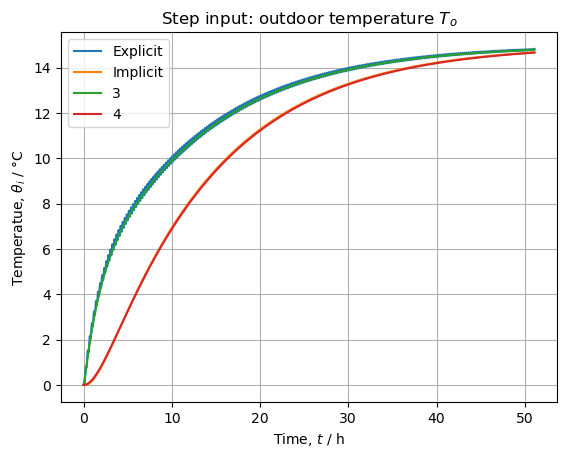

In [37]:
fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time, $t$ / h',
       ylabel='Temperatue, $θ_i$ / °C',
       title='Step input: outdoor temperature $T_o$')
ax.legend(['Explicit', 'Implicit', '3', '4'])
ax.grid()
plt.show()

> Figure 7. Step response to outdoor temperature by using Euler
[implicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method)
and
[explicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) integration.

The value the indoor temperature obtained after the [settling time](https://en.m.wikipedia.org/wiki/Settling_time) is almost equal to the value obtained in steady-state.

In [38]:
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(θ[6]):.4f} °C')
print(f'- state-space model: {float(yss):.4f} °C')
print(f'- steady-state response to step input: {float(y_exp[:, -2]):.4f} °C')

Steady-state indoor temperature obtained with:


NameError: name 'θ' is not defined

### Simulation with weather data

#### Start and end time
The simulation will be done from `start_date` to `end_date` indicated in the format `MM-DD HH:MM:SS` (month, day, hour:minute:second).

In [ ]:
start_date = '02-01 12:00:00'
end_date = '02-07 18:00:00'

The weather data are for a year. The choice of `2000` for the year is arbitrary; it used in order to respect the format `YYYY-MM-DD HH:MM:SS`.

In [ ]:
start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

#### Inputs
##### Read weather data
Dynamic simulation needs [time series](https://en.m.wikipedia.org/wiki/Time_series) of weather data for air temperature, direct solar radiation on a normal surface and diffuse solar radiation on an horizontal surface (see the tutorial on [Weather data and solar radiation](../t01/t01ReadWeatherData.ipynb)).

From the weather data, we select:
- hourly outdoor air temperature, °C;
- hourly solar [direct normal irradiance](https://en.m.wikipedia.org/wiki/Direct_insolation) (or beam radiation), W/m²;
- hourly solar diffuse horizontal irradiance (or [diffuse sky radiation](https://en.wikipedia.org/wiki/Diffuse_sky_radiation)), W/m².

In [ ]:
filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

The year is set to `2000` by convention and the data is selected from start to end.

In [ ]:
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]

##### Solar irradiance on the walls
For the surface orientation given by `slope`, `azimuth`and `latitude`, and the `albedo` of the surface in front of the wall, by using the weather data, we can calculate the:
- direct irradiance, W/m²,
- diffuse irradiance, W/m²,
- reflected irradiance, W/m²,

for hourly solar [irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance) on a tilted surface.

In [ ]:
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, albedo)
# pd.DataFrame(rad_surf)

The total solar [irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance)  $E_{tot}$, in W/m², is the sum of direct, diffuse, and reflected components.  

In [ ]:
rad_surf['Φtot'] = rad_surf.sum(axis=1)

##### Resample the weather data
The weather data is at the time-step of 1h. It needs to be resampled at time step $\Delta t$ used for numerical integration.

In [ ]:
# resample weather data
data = pd.concat([weather['temp_air'], rad_surf['Φtot']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})
data = data.rename_axis('Time')
# pd.DataFrame(data)

##### Other inputs
Let's consider the indoor temperature setpoint $T_{i,sp} = 20 \, \mathrm{^\circ C}$ and the auxiliary heat flow $\dot{Q}_a = 0 \, \mathrm{W}$ constant for the whole duration of the simulation.

In [ ]:
data['Ti'] = 20 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])
# pd.DataFrame(data)

##### Input vector in time
The input is formed by the vectors of time series of temperature sources $\left [ T_o, T_o ,T_o, T_{i,sp} \right ]^T$ and vectors of time series of the heat flow sources $\left [ \Phi_o, \Phi_i, \dot{Q_a}, \Phi_a \right ]^T$:

$$u = 
\begin{bmatrix}
T_o\\ 
T_o\\ 
T_o\\ 
T_{i,sp}\\ 
\Phi_o\\ 
\Phi_i\\ 
\dot{Q}_a\\ 
\Phi_a
\end{bmatrix}
= \begin{bmatrix}
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
 T_{i,sp(0)} & T_{i,sp(1)}& ... & T_{i,sp(n-1)}\ \\ 
\Phi_{o,(0)} & \Phi_{o,(1)} & ... & \Phi_{o,(n-1)}\\
\Phi_{i,(0)} & \Phi_{i,(1)} & ... & \Phi_{i,(n-1)}\\ 
 \dot{Q}_{a(0)} & \dot{Q}_{a(1)} & ... & \dot{Q}_{a(n-1)}\\ 
\Phi_{a,(0)} & \Phi_{a,(1)} & ... & \Phi_{a,(n-1)}
\end{bmatrix}$$

where:

$T_o$: the time series vector of outdoor temperatures (from weather data), °C.

$T_{i,sp}$: time series vector of indoor setpoint temperatures, °C.

$\Phi_o$: time series vector of solar (i.e. short wave) radiation, in W, absorbed by the outdoor surface of the wall:

$$\Phi_o = \alpha_{w,SW} S_w E_{tot}$$

where:

- $\alpha_{w,SW}$ is the absortion coefficient of the outdoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_w$ - surface area of the wall, m²;
- $E_{tot}$ - total solar irradiation on the wall, W/m².

$\Phi_i$: time series vector of short wave (i.e. solar) radiation, in W, absorbed by the indoor surfaces of the wall:

$$\Phi_i = \tau_{g,SW}  \alpha_{w,SW} S_g E_{tot}$$

where:
- $\tau_{g,SW}$ is the transmission coefficient of the window glass, $0 \leqslant \tau_{g,SW} \leqslant 1$;
- $\alpha_{w,SW}$ - absortion coefficient of the indoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_g$ - surface area of the window glass, m²;
- $E_{tot}$ - total solar radiation intensity on the wall, W/m².

$\dot{Q}_a$: time vector of auxiliary heat flows (from occupants, electrical devices, etc.), W.

$\Phi_a$: time series vector of short wave (i.e. solar) radiation, in W, absorbed by the window glass:

$$\Phi_a = \alpha_{g,SW} S_g E_{tot}$$

where:
- $\alpha_{g,SW}$ is the absortion coefficient of the glass window in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_g$ - surface area of the glass window, m²;
- $E_{tot}$ - total solar irradiation on the wall, W/m².

In [ ]:
# input vector
To = data['To']
Ti = data['Ti']
Φo = α_wSW * wall['Surface']['Layer_out'] * data['Φtot']
Φi = τ_gSW * α_wSW * wall['Surface']['Glass'] * data['Φtot']
Qa = data['Qa']
Φa = α_gSW * wall['Surface']['Glass'] * data['Φtot']

u = pd.concat([To, To, To, Ti, Φo, Φi, Qa, Φa], axis=1)
u.columns.values[[4, 5, 7]] = ['Φo', 'Φi', 'Φa']
pd.DataFrame(u)

#### Initial conditions
The initial value of the state-vector can be zero or different from zero.

In [ ]:
θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])

#### Time integration
[Explicit Euler](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) integration in time,

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

where $k = 0, ... , n - 1$,

In [ ]:
for k in range(u.shape[0] - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]

yields the time variation of state variable $\theta$, from which we obtain the variation of the output (i.e. indoor temperature):

$$y = C_s \theta_s + D_s u$$

and the variation of the heat flow of the HVAC system:

$$q_{HVAC} = K_p (T_{i,sp} - \theta_i) = K_p (T_{i,sp} - y)$$

where $K_p$ is the gain of the P-controller and $T_{i,sp}$ is the HVAC-setpoint for the indoor temperature.

In [ ]:
y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Ti'] - y_exp[0, :])

In [ ]:
data['θi_exp'] = y_exp.T
data['q_HVAC'] = q_HVAC.T

In [ ]:
fig, axs = plt.subplots(2, 1)

data[['To', 'θi_exp']].plot(ax=axs[0],
                            xticks=[],
                            ylabel='Temperature, $θ$ / °C')
axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              loc='upper right')

data[['Φtot', 'q_HVAC']].plot(ax=axs[1],
                              ylabel='Heat rate, $q$ / W')
axs[1].set(xlabel='Time')
axs[1].legend(['$Φ_{total}$', '$q_{HVAC}$'],
             loc='upper right')
plt.show()

> Figure 6. Simulation in free-running with weather data using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

In [ ]:
t = dt * np.arange(data.shape[0])   # time vector

fig, axs = plt.subplots(2, 1)
# plot outdoor and indoor temperature
axs[0].plot(t / 3600 / 24, data['To'], label='$θ_{outdoor}$')
axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$θ_{indoor}$')
axs[0].set(ylabel='Temperatures, $θ$ / °C',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24, data['Φtot'], label='$Φ_{total}$')
axs[1].plot(t / 3600 / 24, q_HVAC, label='$q_{HVAC}$')
axs[1].set(xlabel='Time, $t$ / day',
           ylabel='Heat flows, $q$ / W')
axs[1].legend(loc='upper right')

fig.tight_layout()

> Figure 7. Simulation in free-running with weather data using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

## Discussion

Interchange the materials  of the layers of the wall. Discuss the step responses and the simuation for weather. Give arguments for the advantages and the disadvanted of indoor and outdoor insulation.

The time step depends on:

- P-controller gain `Kp`:
    - if $K_p \rightarrow \infty$, then the controller is perfect and the time step needs to be small;
    - if $K_p \rightarrow 0$, then, the controller is ineffective and the building is in free-running.
- Capacities considered into the model:
    - if the capacities of the air $C_a =$ `C['Air']` and of the glass $C_g =$ `C['Glass']` are considered, then the time step is small;
    - if the capacities of the air and of the glass are zero, then the time step is large (and the order of the state-space model is reduced).

The controller models an HVAC system able to heat (when $q_{HVAC} > 0$) and to cool (when $q_{HVAC} < 0$).

## References

1. C. Ghiaus (2013) Causality issue in the heat balance method for calculating the design heating and cooling loads, *Energy* 50: 292-301, https://doi.org/10.1016/j.energy.2012.10.024, open access preprint: [HAL-03605823](https://hal.archives-ouvertes.fr/hal-03605823/document)

2. C. Ghiaus (2021). Dynamic Models for Energy Control of Smart Homes, in *S. Ploix M. Amayri, N. Bouguila (eds.) Towards Energy Smart Homes*, Online ISBN: 978-3-030-76477-7, Print ISBN: 978-3-030-76476-0, Springer, pp. 163-198 (ref.)
[DOI 10.1007/978-3-030-76477-7_5](https://doi.org/10.1007/978-3-030-76477-7_5), open access preprint: [HAL 03578578](https://hal.archives-ouvertes.fr/hal-03578578/document)

3. J.A. Duffie, W. A. Beckman, N. Blair (2020) [Solar Engineering of Thermal Processes](https://www.eng.uc.edu/~beaucag/Classes/SolarPowerForAfrica/Solar%20Engineering%20of%20Thermal%20Processes,%20Photovoltaics%20and%20Wind.pdf), 5th ed. John Wiley & Sons, Inc. ISBN 9781119540281

4. [Réglementation Thermique 2005. Méthode de calcul Th-CE.](https://pdfslide.fr/documents/rt2005-methode-de-calcul-th-ce.html) Annexe à l’arrêté du 19 juillet 2006

5. H. Recknagel, E. Sprenger, E.-R. Schramek (2013) Génie climatique, 5e edition, Dunod, Paris. ISBN 978-2-10-070451-4

§. J.R. Howell et al. (2021) Thermal Radiation Heat Transfer 7th edition, ISBN 978-0-367-34707-0, [A Catalogue of Configuration Factors](http://www.thermalradiation.net/indexCat.html)

7. J. Widén, J. Munkhammar (2019) [Solar Radiation Theory](http://www.diva-portal.org/smash/get/diva2:1305017/FULLTEXT01.pdf), Uppsala University

# [Thermal circuits assembling](04AssemblingCircuits.ipynb)

# [Switch between models: heating & cooling and free-running](05SwitchModels.ipynb)

# [Control input: heating & cooling and free-running](06Control_Input.ipynb)

# [Radiation coupled with convection](07Coupled_rad_convection.ipynb)

# [Sensible thermal load in steady-state](08Thermal_load.ipynb)

# [Air flow by ventilation](09Air_flow_ventilation.ipynb)